In [1]:
import matplotlib.pyplot as plt
import sys

# Add the path to the library folder
sys.path.append('./lib')

import numpy as np

In [247]:
seed = 2314871
np.random.seed(seed)

In [273]:
# Collect Tommaso's data
fk_grid = np.load('Tommaso/fk_grid.npy')
data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
Cy = np.load('Tommaso/Cy.npy')
Cinv = np.linalg.inv(Cy)
y = FK @ f_bcdms
y_noise = np.load('Tommaso/L1_noise_BCDMS.npy')

Cinv_sqrt = np.linalg.cholesky(Cinv)
assert(np.allclose(Cinv_sqrt @ Cinv_sqrt.T, Cinv))
#y_noise = Cinv_sqrt @ np.random.normal(size=(Cinv.shape[0], 1))
y_noisy = y + y_noise.reshape(-1) @ np.random.normal(size=(Cinv.shape[0], 1))

# Remove unnecessary zero columns
#non_zero_columns = ~np.all(np.isclose(FK, 0), axis=0)
#FK = FK[:, non_zero_columns]
#xgrid = fk_grid[non_zero_columns]

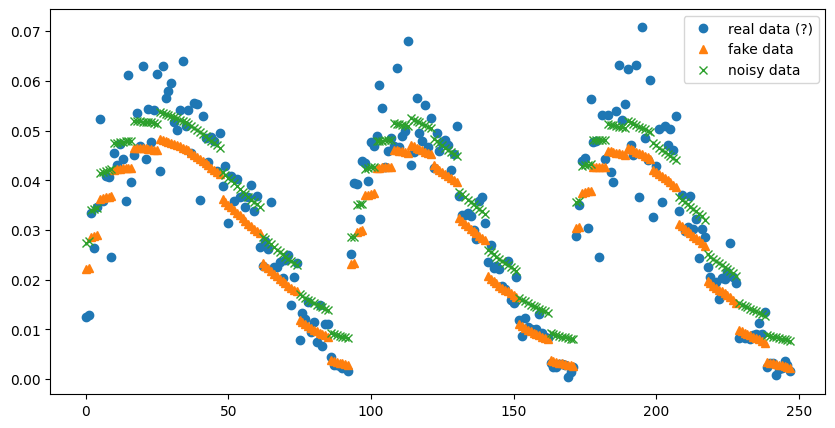

In [274]:
plt.figure(figsize=(10, 5))
_ = plt.plot(data, 'o', label='real data (?)')
_ = plt.plot(y, '^', label='fake data')
_ = plt.plot(y_noisy, 'x', label='noisy data')
plt.legend()

In [275]:
U, S, Vh = np.linalg.svd(FK, full_matrices=False)

norm_FK = np.linalg.norm(FK)
two_norm = np.linalg.norm(FK, ord=2)
quad_S = np.sqrt(np.sum([s**2 for s in S]))

print(f"Frobenius norm of FK: {norm_FK}")
print(f"Quadratic norm of singular values: {quad_S}")
print(f"Two norm of FK: {two_norm}")
print(f"Largest singular values of FK: {S[0]}")
print("--------------------------")
print(f"Shape of U: {U.shape}")
print(f"Shape of V: {Vh.T.shape}")
print("--------------------------")
print(f"Condition number of FK: {S[0] / S[-1]}")

Frobenius norm of FK: 1.476727047564019
Quadratic norm of singular values: 1.476727047564019
Two norm of FK: 0.580975123121814
Largest singular values of FK: 0.5809751231218141
--------------------------
Shape of U: (248, 50)
Shape of V: (50, 50)
--------------------------
Condition number of FK: 8.33105601517087e+17


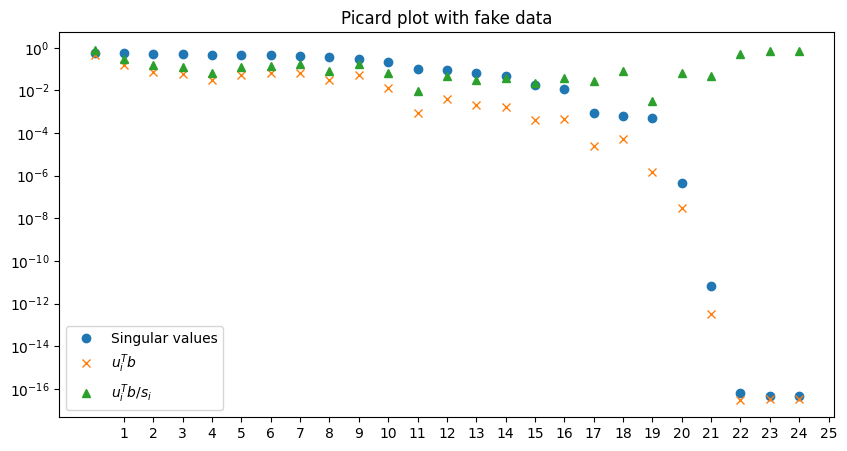

In [276]:
# Picard plot
rank = 25
coeff_data = U.T @ y
coeff_data_sol = np.array([c / s for c, s in zip(coeff_data, S)])

_ = plt.figure(figsize=(10, 5))
_ = plt.plot(S[:rank], 'o', label='Singular values')
_ = plt.plot(np.abs(coeff_data)[:rank], 'x', label=r'$u_i^T b$')
_ = plt.plot(np.abs(coeff_data_sol)[:rank], '^', label=r'$u_i^T b / s_i$')
plt.title('Picard plot with fake data')
plt.yscale('log')
_ = plt.xticks(np.arange(1, rank+1, 1))
_ = plt.legend()

The coefficients $|\pmb{u_i^T} \cdot \pmb{y}|$ decay faster than the singular values, until they level off for $i \gtrapprox 20$ at a plateau determined by the machine precision, and these tiny coefficients are less than the machine precision times $||\pmb{y}||^2$. Hence, the Picard condition is satisfied as long as we discard all the numerical noise below $i = 20$.

Note also that the Picard plot changes dramatically when using real data

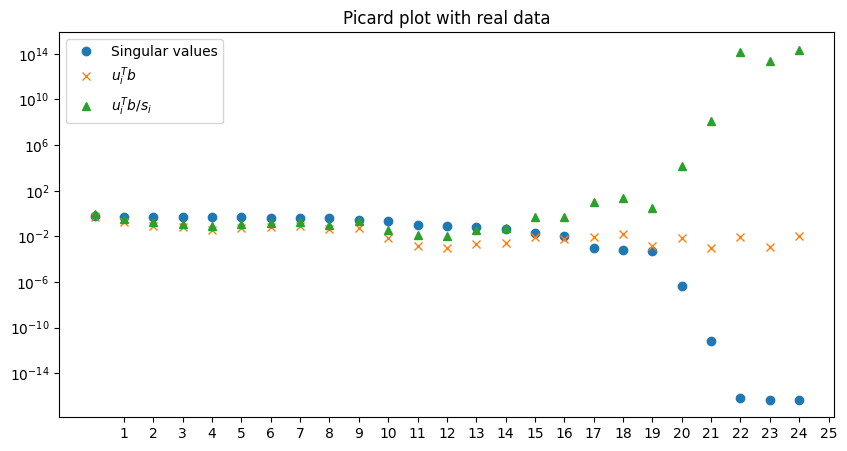

In [277]:
# Picard plot
rank = 25
coeff_data = U.T @ data
coeff_data_sol = np.array([c / s for c, s in zip(coeff_data, S)])

_ = plt.figure(figsize=(10, 5))
_ = plt.plot(S[:rank], 'o', label='Singular values')
_ = plt.plot(np.abs(coeff_data)[:rank], 'x', label=r'$u_i^T b$')
_ = plt.plot(np.abs(coeff_data_sol)[:rank], '^', label=r'$u_i^T b / s_i$')
plt.title('Picard plot with real data')
plt.yscale('log')
_ = plt.xticks(np.arange(1, rank+1, 1))
_ = plt.legend()

and with noisy data: **NEED TO INVESTIGATE THAT BETTER**

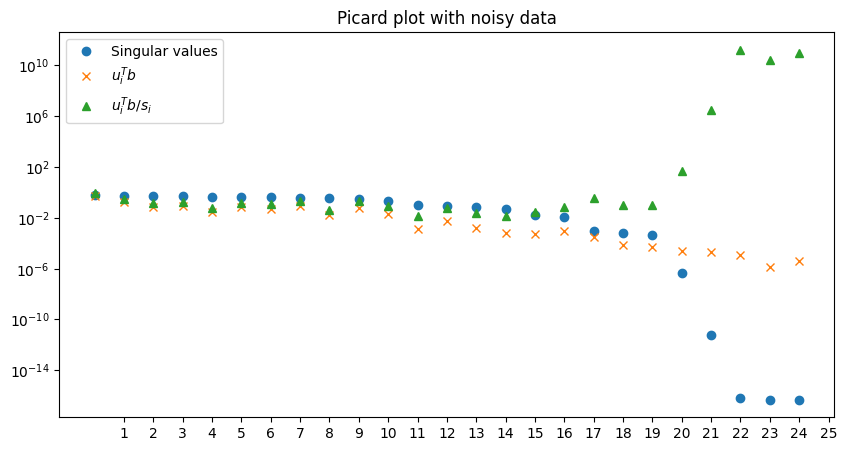

In [283]:
# Picard plot
rank = 25
coeff_data = U.T @ y_noisy
coeff_data_sol = np.array([c / s for c, s in zip(coeff_data, S)])

_ = plt.figure(figsize=(10, 5))
_ = plt.plot(S[:rank], 'o', label='Singular values')
_ = plt.plot(np.abs(coeff_data)[:rank], 'x', label=r'$u_i^T b$')
_ = plt.plot(np.abs(coeff_data_sol)[:rank], '^', label=r'$u_i^T b / s_i$')
plt.title('Picard plot with noisy data')
plt.yscale('log')
_ = plt.xticks(np.arange(1, rank+1, 1))
_ = plt.legend()

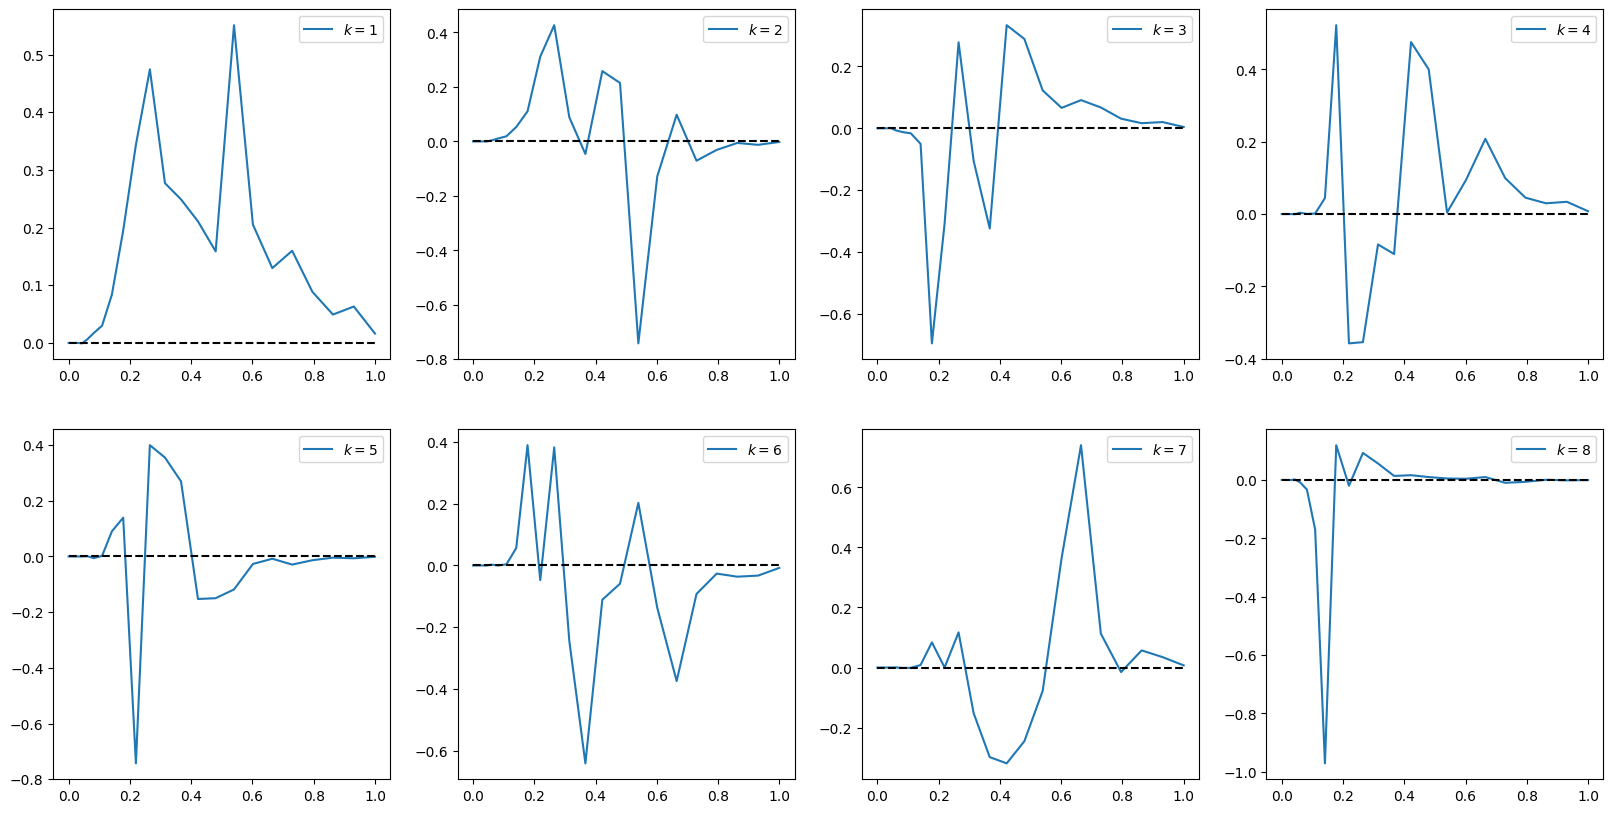

In [279]:
# Plot the components of the right singular vectors
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
rank_vecs = np.arange(0, 9)

for k, ax in zip(rank_vecs, axs.flatten()):
    ax.plot(fk_grid, Vh.T[:, k], label=f'$k = {k+1}$')
    ax.plot(fk_grid, np.zeros_like(fk_grid), 'k--')
    ax.legend()

# Truncated SVD

Note that this solution already implements the constraint $\textrm{min} ||x^2||$.

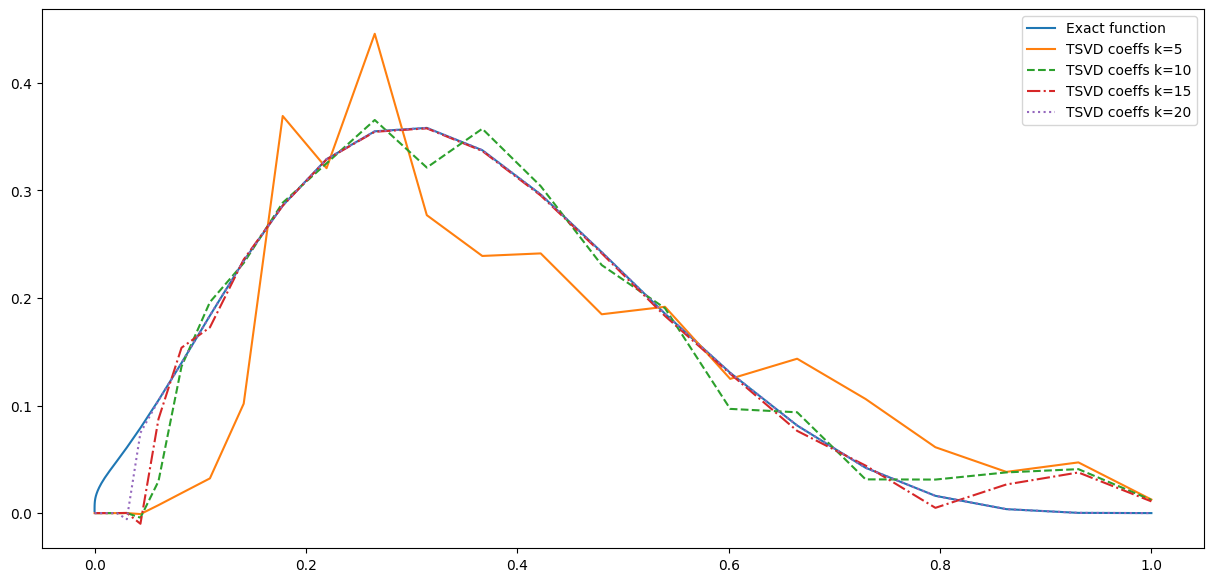

In [280]:
U, S, Vh = np.linalg.svd(FK, full_matrices=False)
linestyles = ['-', '--', '-.', ':', '-']
markers = ['','','','','o']

plt.figure(figsize=(15, 7))
plt.plot(fk_grid, f_bcdms, label='Exact function')

for idx, k in enumerate([5, 10, 15, 20]):
  f_tsvd_coeffs = np.array([np.dot(U[:, i], y) / S[i] for i in range(k)])
  f_tsvd = np.sum([f_tsvd_coeffs[i] * Vh[i, :] for i in range(k)], axis=0)
  plt.plot(fk_grid, f_tsvd, label='TSVD coeffs k={}'.format(k), ls=linestyles[idx], marker=markers[idx])

plt.legend()

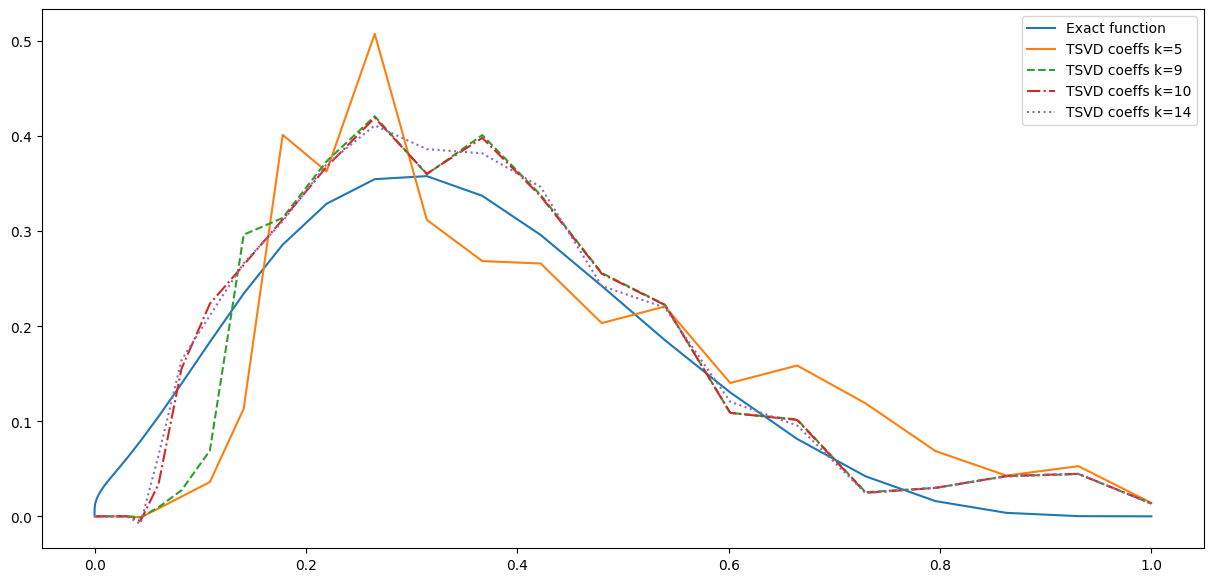

In [ ]:
# Here I use real data instead of `y`. which should be the real data?
plt.figure(figsize=(15, 7))
plt.plot(fk_grid, f_bcdms, label='Exact function')

for idx, k in enumerate([5, 9, 10, 14]):
  f_tsvd_coeffs = np.array([np.dot(U[:, i], data) / S[i] for i in range(k)])
  f_tsvd = np.sum([f_tsvd_coeffs[i] * Vh[i, :] for i in range(k)], axis=0)
  plt.plot(fk_grid, f_tsvd, label='TSVD coeffs k={}'.format(k), ls=linestyles[idx], marker=markers[idx])

plt.legend()

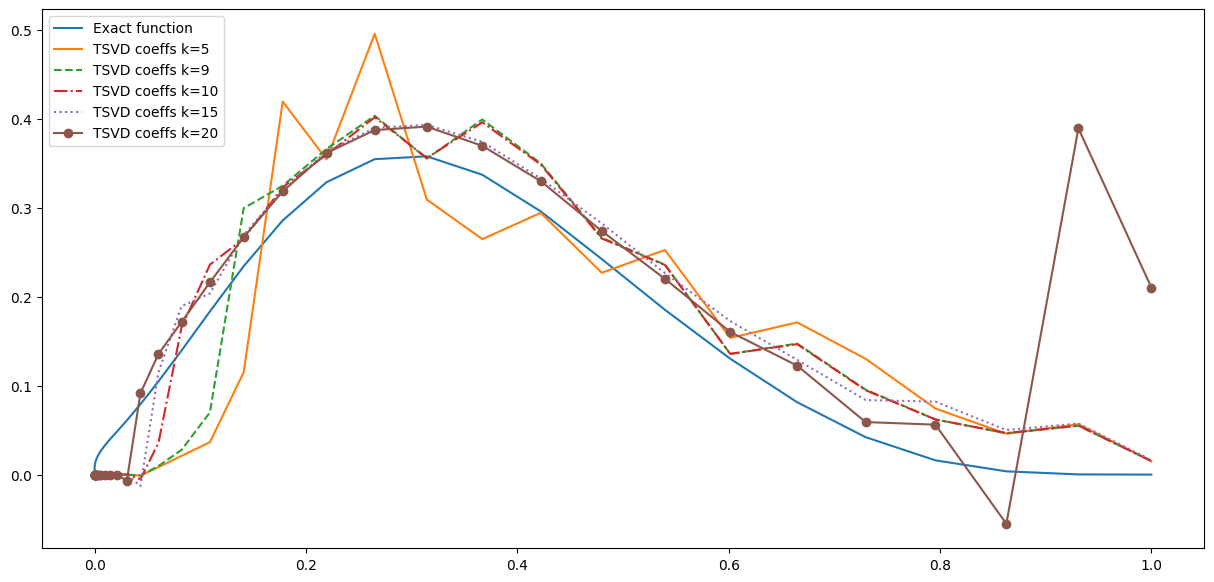

In [285]:
# Here I use noisy data instead of `y`. which should be the real data?
plt.figure(figsize=(15, 7))
plt.plot(fk_grid, f_bcdms, label='Exact function')

for idx, k in enumerate([5, 9, 10, 15, 20]):
  f_tsvd_coeffs = np.array([np.dot(U[:, i], y_noisy) / S[i] for i in range(k)])
  f_tsvd = np.sum([f_tsvd_coeffs[i] * Vh[i, :] for i in range(k)], axis=0)
  plt.plot(fk_grid, f_tsvd, label='TSVD coeffs k={}'.format(k), ls=linestyles[idx], marker=markers[idx])

plt.legend()

# This part is pure magic

rtol: 5.205365564207722e-14
Two norm of FK_tilde: 54956.87359372595
Largest singular values of FK_tilde: 54956.873593725875
Upper bound: 3.639217206541251e-05
Inversion of Sigma: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


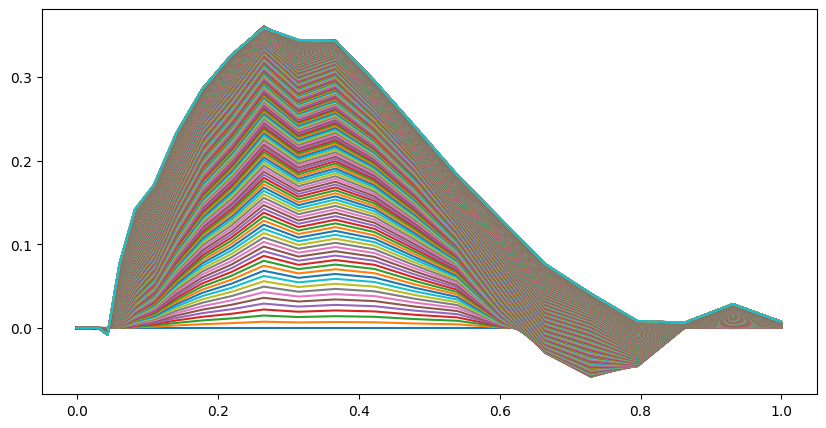

In [183]:
FK_tilde = Cinv_sqrt @ FK
b_tilde = Cinv_sqrt @ y

U, S, Vh = np.linalg.svd(FK_tilde, full_matrices=True)
rtol = np.amax(S, initial=0.) * np.finfo(FK_tilde.dtype).eps

Sigma = np.zeros((U.shape[0], Vh.shape[0]))
Sigma[:Vh.shape[0], :Vh.shape[0]] = np.diag(S)
condition = S > rtol
S_inv = np.array([1/S[idx] if condition[idx] else 0.0 for idx in range(S.size)])
Sigma_inv = np.zeros((Vh.shape[0], U.shape[0]))
Sigma_inv[:Vh.shape[0], :Vh.shape[0]] = np.diag(S_inv)


two_norm = np.linalg.norm(FK_tilde.T @ FK_tilde, ord=2)
print(f"rtol: {rtol}")
print(f"Two norm of FK_tilde: {two_norm}")
print(f"Largest singular values of FK_tilde: {S[0]**2}")
print(f"Upper bound: {2 / two_norm}")


def phi_k(k, omega):
  return np.array([1 - np.power(1 - omega * sigma_i, k) for sigma_i in S])

def f_k(k, omega):
  Phi = np.diag(phi_k(k, omega))
  return Vh.T @ Phi @ Sigma_inv @ U.T @ b_tilde

print(f"Inversion of Sigma: {np.diag(Sigma_inv @ Sigma)}") 

plt.figure(figsize=(10, 5))
for k in range(1, 10000000, 20000):
  plt.plot(fk_grid, f_k(k, 1.e-8), label=f'k={k}')

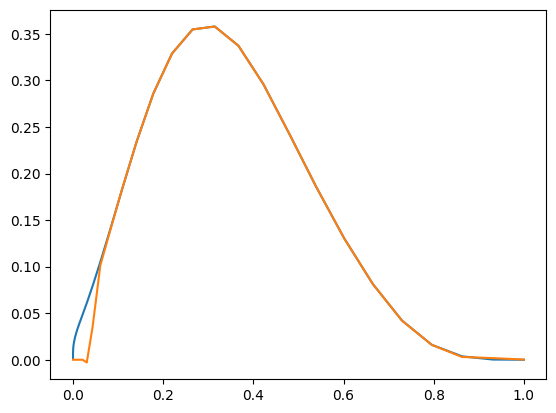

In [184]:
k = 10000
plt.plot(fk_grid, f_bcdms)
plt.plot(fk_grid, f_k(k, 1.e-3))